In [1]:
import pandas as pd
import numpy as np
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon
from pyproj import Geod
from geopy.distance import geodesic
import geopandas
world = geopandas.read_file('../geopandas/world_m.shp')
import matplotlib.pyplot as plt
import time

In [2]:
localityFeatures = pd.read_csv('../csv/localityFeatures500.csv', index_col=0)
df = pd.read_csv('../csv/NOW_dataframe_cleaned.csv', index_col=0)
speciesFirstOccurrence = pd.read_csv('../csv/speciesFirstOccurrence.csv', index_col=0)
speciesLastOccurrence = pd.read_csv('../csv/speciesLastOccurrence.csv', index_col=0)
timeUnits = ['old','MN1','MN2','MN3','MN4','MN5','MN6','MN7-8','MN9','MN10','MN11','MN12','MN13','MN14','MN15','MN16','MN17','MQ18','MQ19','recent']
# specify a named ellipsoid
geod = Geod(ellps="WGS84")

pd.set_option('max_columns',100)

In [3]:
timeBoundaries = [23,21.7,19.5,17.2,16.4,14.2,12.85,11.2,9.9,8.9,7.6,7.1,5.3,5,3.55,2.5,1.9,0.85,0.01,0]

In [4]:
# # only including species that were "born" in or after MN1 within the study area
# allowed_species = []
# for timeUnit in timeUnits[1:-1]:
#     all_species = speciesFirstOccurrence.loc[speciesFirstOccurrence[timeUnit]==1].index
#     for species in all_species:
#         occurrences = df[(df['ID']==species) & (df['TIMEUNIT']==timeUnit)]
#         if ( occurrences.loc[(occurrences['LAT']>35) & (occurrences['LONG']>-25) \
#                            & (occurrences['LONG']<40)].shape[0] ) > 0:
#             allowed_species.append(species)

In [5]:
# only including species that were "born" in or after MN2 and "died" in or before MQ18 within the study area
allowed_species_1 = []
for timeUnit in timeUnits[2:-2]:
    all_species = speciesFirstOccurrence.loc[speciesFirstOccurrence[timeUnit]==1].index
    for species in all_species:
        occurrences = df[(df['ID']==species) & (df['TIMEUNIT']==timeUnit)]
        if ( occurrences.loc[(occurrences['LAT']>35) & (occurrences['LONG']>-25) \
                           & (occurrences['LONG']<40)].shape[0] ) > 0:
            allowed_species_1.append(species)
            
allowed_species_2 = []
for timeUnit in timeUnits[2:-2]:
    all_species = speciesLastOccurrence.loc[speciesLastOccurrence[timeUnit]==1].index
    for species in all_species:
        occurrences = df[(df['ID']==species) & (df['TIMEUNIT']==timeUnit)]
        if ( occurrences.loc[(occurrences['LAT']>35) & (occurrences['LONG']>-25) \
                           & (occurrences['LONG']<40)].shape[0] ) > 0:
            allowed_species_2.append(species)

In [6]:
print(len(allowed_species_1))
print(len(allowed_species_2))
print(sorted(allowed_species_1)[0:10])
print(sorted(allowed_species_2)[0:10])

2379
2287
[0, 1, 2, 4, 5, 6, 7, 8, 9, 10]
[0, 4, 5, 6, 7, 8, 9, 10, 11, 12]


In [7]:
allowed_species = [x for x in allowed_species_1 if x in allowed_species_2] 
print(len(allowed_species))
print(sorted(allowed_species)[0:10])

2156
[0, 4, 5, 6, 7, 8, 9, 10, 11, 12]


In [8]:
timeUnits[2:18]

['MN2',
 'MN3',
 'MN4',
 'MN5',
 'MN6',
 'MN7-8',
 'MN9',
 'MN10',
 'MN11',
 'MN12',
 'MN13',
 'MN14',
 'MN15',
 'MN16',
 'MN17',
 'MQ18']

In [9]:
speciesLifespan = pd.DataFrame(index=allowed_species,columns=['GENUS','SPECIES','LIFESPAN (time units)','LIFESPAN (My)'])
speciesRange = pd.DataFrame(index=allowed_species,columns=timeUnits[2:18])

# count expections
count_1 = 0
count_2 = 0
count_3 = 0
count_other = 0

tic = time.process_time()
for species in speciesLifespan.index:
    timeUnitFirst = timeUnits.index(speciesFirstOccurrence.loc[species].idxmax())
    timeUnitLast = timeUnits.index(speciesLastOccurrence.loc[species].idxmax())        
    speciesLifespan.loc[species,'GENUS'] = df.loc[df['ID']==species,'GENUS'].unique()[0]
    speciesLifespan.loc[species,'SPECIES'] = df.loc[df['ID']==species,'SPECIES'].unique()[0]
    speciesLifespan.loc[species,'LIFESPAN (time units)'] = timeUnitLast - timeUnitFirst + 1
    speciesLifespan.loc[species,'LIFESPAN (My)'] = timeBoundaries[timeUnitFirst-1] - timeBoundaries[timeUnitLast]
    for timeUnit in timeUnits[timeUnitFirst:timeUnitLast+1]:
        occurrences = df[(df['TIMEUNIT']==timeUnit) & (df['ID']==species)]        
        if occurrences.shape[0]>0:
            # area by convex hull (calculate where possible)
            points = occurrences[['LONG','LAT']]
            try:            
                hull = ConvexHull(points)
                poly = Polygon(hull.points[np.append(hull.vertices, hull.vertices[0])])
                speciesRange.loc[species,timeUnit] = abs(geod.geometry_area_perimeter(poly)[0] / 10**6)            
            except: 
                # not enough unique occurrences (3) 
                if points.shape[0]==1:
                    speciesRange.loc[species,timeUnit] = 0
                    count_1 += 1
                # with two points, estimate area as a 10km wide rectangle between the two points
                elif points.shape[0]==2:
                    speciesRange.loc[species,timeUnit] = 10*geodesic(points.iloc[0][['LAT','LONG']],\
                                                                     points.iloc[1][['LAT','LONG']]).km
                    count_2 += 1
                #  points really close by each other may not allow convex hull to be calculated
                elif points.shape[0] > 2:
                    speciesRange.loc[species,timeUnit] = 0 
                    count_3 += 1
                else:
                    speciesRange.loc[species,timeUnit] = np.nan
                    count_other += 1
                    

toc = time.process_time()
print('Time elapsed: ' + str((toc-tic)/60) + ' minutes.')         
print()

nr_areas_calculated = (~speciesRange.isnull()).sum().sum() 

print('count_1: ' + str(count_1))
print('Percentage: ' + str(count_1 / nr_areas_calculated))
print()
print('count_2: ' + str(count_2))
print('Percentage: ' + str(count_2 / nr_areas_calculated))
print()
print('count_3: ' + str(count_3))
print('Percentage: ' + str(count_3 / nr_areas_calculated))
print()
print('count_other: ' + str(count_other))
print('Percentage: ' + str(count_other / nr_areas_calculated))
print()

display(speciesLifespan.head(10))
display(speciesRange.head(10))

Time elapsed: 0.33027029999999985 minutes.

count_1: 1955
Percentage: 0.45098039215686275

count_2: 756
Percentage: 0.17439446366782008

count_3: 73
Percentage: 0.016839677047289503

count_other: 0
Percentage: 0.0



,GENUS,SPECIES,LIFESPAN (time units),LIFESPAN (My)
17,Heteroxerus,rubricati,7,11.8
39,Microdyromys,koenigswaldi,7,11.8
86,Pseudodryomys,ibericus,5,8.85
104,Styriofelis,turnauensis,8,12.8
109,Lagopsis,penai,5,8.85
147,Aureliachoerus,aurelianensis,5,8.85
148,Simplomys,simplicidens,5,8.85
150,Glirudinus,modestus,4,7.5
152,Armantomys,parsani,2,4.5
153,Simplomys,robustus,4,7.5


,MN2,MN3,MN4,MN5,MN6,MN7-8,MN9,MN10,MN11,MN12,MN13,MN14,MN15,MN16,MN17,MQ18
17,5190.185545,107106.894434,395643.025852,291217.321935,76965.807198,740.772629,17.807243,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39,10113.528911,158964.927053,427346.453883,423078.455947,145454.295644,480340.542893,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
86,71008.527356,321672.133534,577456.723594,200846.691223,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
104,0,425781.220279,407417.621974,892924.923445,NaN,3022.973629,10487.221353,36757.232954,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
109,0,106350.795885,669949.852129,635790.466065,5811.071623,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
147,6186.078527,536460.396214,879736.501732,35178.392395,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
148,23559.337995,326357.377524,706402.035439,219479.27964,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
150,67945.6832,411507.945678,315143.148877,24540.556145,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
152,0,17961.411136,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
153,1202.104707,164103.676316,11055.315335,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
world = world.to_crs(epsg=4326)
myMap = world.cx[:,:]

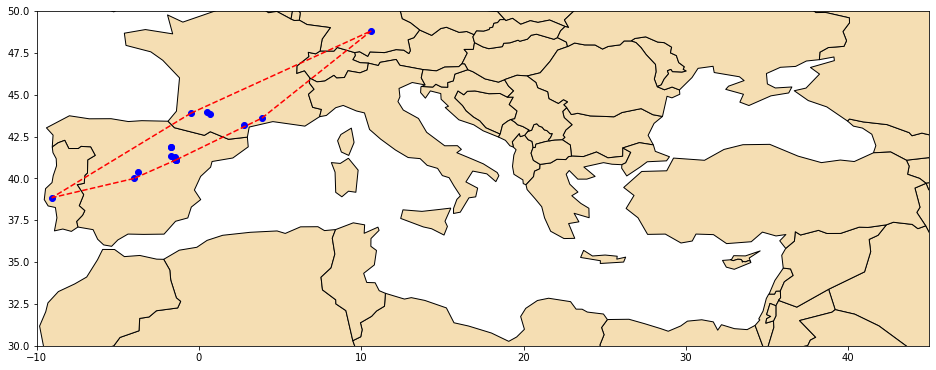

,LIDNUM,NAME,LATSTR,LONGSTR,LAT,LONG,MAX_AGE,BFA_MAX,BFA_MAX_ABS,FRAC_MAX,MIN_AGE,BFA_MIN,BFA_MIN_ABS,FRAC_MIN,CHRON,COUNTRY,STATE,COUNTY,APNUMSPM,GENERAL,LOC_SYNONYMS,MEAN_HYPSODONTY,ESTIMATE_PRECIP,ESTIMATE_TEMP,ESTIMATE_NPP,PERS_WOODY_COVER,PERS_POLLEN_AP,PERS_POLLEN_NAP,PERS_POLLEN_OTHER,SIDNUM,ORDER,FAMILY,GENUS,SPECIES,SUBCLASSORSUPERORDER,SUBORDERORSUPERFAMILY,SUBFAMILY,UNIQUE,TAXON_STATUS,ID_STATUS,ADD_INFO,SOURCE_NAME,LS_MICROWEAR,LS_MESOWEAR,LS_MESOWEAR_SCORE,LS_MW_OR_HIGH,LS_MW_OR_LOW,LS_MW_CS_SHARP,LS_MW_CS_ROUND,LS_MW_CS_BLUNT,SVLENGTH,BODYMASS,SXDIMSZE,SXDIMDIS,TSHM,TCRWNHT,HORIZODONTY,CROWNTYP,CUSP_SHAPE,CUSP_COUNT_BUCCAL,CUSP_COUNT_LINGUAL,LOPH_COUNT_LON,LOPH_COUNT_TRS,FCT_AL,FCT_OL,FCT_SF,FCT_OT,FCT_CM,MICROWEAR,MESOWEAR,MESOWEAR_SCORE,MW_OR_HIGH,MW_OR_LOW,MW_CS_SHARP,MW_CS_ROUND,MW_CS_BLUNT,DIET_1,DIET_2,DIET_3,LOCOMO1,LOCOMO2,LOCOMO3,SPCOMMENT,SYNONYMS,MEAN_AGE,TIMEUNIT,ID,HYP,LOP
1075,27274.0,Alhambra-Túneles,40 24 17 N,3 43 21 W,40.404739,-3.722606,14.2,mn6,\N,\N,12.85,mn6,\N,\N,\N,Spain,Madrid,\N,\N,\N,Túneles,1.20,\N,\N,\N,\N,\N,\N,\N,21064.0,Rodentia,Sciuridae,Heteroxerus,grivensis,Eutheria,\N,\N,-,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,149,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,p,herbivore,\N,\N,\N,\N,\N,\N,13.525,MN6,24.0,NaN,NaN
2080,21510.0,Armantes 7,41 21 45 N,1 43 21 W,41.362600,-1.722700,14.2,mn6,\N,\N,12.85,mn6,\N,\N,\N,Spain,Aragon,Province of Zaragoza,\N,\N,Armantes VII,\N,\N,\N,\N,\N,\N,\N,\N,21064.0,Rodentia,Sciuridae,Heteroxerus,grivensis,Eutheria,\N,\N,-,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,149,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,p,herbivore,\N,\N,\N,\N,\N,\N,13.525,MN6,24.0,NaN,NaN
2259,20597.0,Arroyo del Val VI,41 10 32 N,1 26 47 W,41.175600,-1.446600,14.2,mn6,\N,\N,12.85,mn6,\N,\N,Aragonian,Spain,Province de Zaragoza,\N,\N,\N,Arroyo del Val 6,1.33,\N,\N,\N,\N,\N,\N,\N,21064.0,Rodentia,Sciuridae,Heteroxerus,grivensis,Eutheria,\N,\N,-,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,149,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,p,herbivore,\N,\N,\N,\N,\N,\N,13.525,MN6,24.0,NaN,NaN
4973,24817.0,Borjas,41 10 9 N,1 26 40 W,41.169400,-1.444500,14.2,mn6,\N,\N,12.85,mn6,\N,\N,Upper Aragonian,Spain,Province of Zaragoza,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,21064.0,Rodentia,Sciuridae,Heteroxerus,grivensis,Eutheria,\N,\N,-,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,149,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,p,herbivore,\N,\N,\N,\N,\N,\N,13.525,MN6,24.0,NaN,NaN
7966,20009.0,Castelnau-d'Arbieu,43 53 00 N,00 42 00 E,43.883000,0.700000,14.2,mn6,\N,\N,12.85,mn6,\N,\N,\N,France,\N,\N,50,n,\N,1.00,\N,\N,\N,\N,\N,\N,\N,21064.0,Rodentia,Sciuridae,Heteroxerus,grivensis,Eutheria,\N,\N,-,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,149,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,p,herbivore,\N,\N,\N,\N,\N,\N,13.525,MN6,24.0,NaN,NaN
16796,26690.0,Cerro de Almodovar 1,40 0 0 N,4 0 0 W,40.000000,-4.000000,14.2,mn6,\N,\N,12.85,mn6,\N,\N,\N,Spain,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,21064.0,Rodentia,Sciuridae,Heteroxerus,grivensis,Eutheria,\N,\N,-,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,149,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,p,herbivore,\N,\N,\N,\N,\N,\N,13.525,MN6,24.0,NaN,NaN
32431,27448.0,La Grenatière,43 36 29 N,3 52 46 E,43.608176,3.879446,16.4,mn5,\N,\N,9.90,mn9,\N,\N,\N,France,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,21064.0,Rodentia,Sciuridae,Heteroxerus,grivensis,Eutheria,\N,\N,-,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,149,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,p,herbivore,\N,\N,\N,\N,\N,\N,13.150,MN6,24.0,NaN,NaN
34336,21535.0,Las Planas 5B,41 11 00 N,01 28 00 W,41.183000,-1.467000,14.2,mn6,\N,\N,12.85,mn6,\N,\N,Upper Aragonian,Spain,Province of Zaragoza,\N,\N,\N,Las Planas,\N,\N,\N,\N,\N,\N,\N,\N,21064.0,Rodentia,Sciuridae,Heteroxerus,grivensis,Eutheria,\N,\N,-,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\

In [11]:
species = 24
timeUnit = 'MN6'

occurrences = df[(df['TIMEUNIT']==timeUnit) & (df['ID']==species)] 
points = occurrences[['LONG','LAT']]
hull = ConvexHull(points)
fig, ax = plt.subplots(figsize=(16,8))
myMap.plot(ax=ax, color='wheat', edgecolor='black')
plt.scatter(hull.points[:,0], hull.points[:,1], c='b')
for simplex in hull.simplices:
    plt.plot(hull.points[simplex,0], hull.points[simplex,1], 'r--')
plt.xlim((-10,45))
plt.ylim((30,50))
plt.show()

display(occurrences)

# FIRST OCCURRENCES

In [12]:
timeUnits[2:-2]

['MN2',
 'MN3',
 'MN4',
 'MN5',
 'MN6',
 'MN7-8',
 'MN9',
 'MN10',
 'MN11',
 'MN12',
 'MN13',
 'MN14',
 'MN15',
 'MN16',
 'MN17',
 'MQ18']

In [13]:
# ADD INFO FOR EACH SPECIES ON THEIR OCCURRENCES IN HOTSPOTS
#for timeUnit in timeUnits[1:-1]:
for timeUnit in timeUnits[2:-2]:
    # determine hotspots and hot spot species
    hotspots = localityFeatures[(localityFeatures['TIMEUNIT']==timeUnit) & \
                                (localityFeatures['SIGNIFICANCE FIRST']<0.05)]
    hotspot_species = set(df.loc[df['LIDNUM'].isin(hotspots.index),'ID'].unique())
    hotspot_species = hotspot_species.intersection(allowed_species)
    biodiversity_hotspots = localityFeatures[(localityFeatures['TIMEUNIT']==timeUnit) & \
                     (localityFeatures['SIGNIFICANCE FIRST']<0.05) & (localityFeatures['SIGNIFICANCE LAST']>0.95)]
    biodiversity_hotspot_species = set(df.loc[df['LIDNUM'].isin(biodiversity_hotspots.index),'ID'].unique())
    biodiversity_hotspot_species = biodiversity_hotspot_species.intersection(allowed_species)
    
    # determine info on first occurrences
    first_occurring_species = speciesFirstOccurrence.loc[speciesFirstOccurrence[timeUnit]==1].index
    species_with_first_occurrence_in_hotspot = hotspot_species.intersection(first_occurring_species)
    species_with_first_occurrence_in_biodiversity_hotspot = \
                biodiversity_hotspot_species.intersection(first_occurring_species)
    
    # import info to speciesLifespan dataframe
    speciesLifespan.loc[species_with_first_occurrence_in_hotspot,'FIRST OCCURRENCE IN HOTSPOT'] = 'yes'
    speciesLifespan.loc[hotspot_species,'ANY OCCURRENCE IN HOTSPOT'] = 'yes'        
    
    speciesLifespan.loc[species_with_first_occurrence_in_biodiversity_hotspot,\
                        'FIRST OCCURRENCE IN BIODIVERSITY HOTSPOT'] = 'yes'    
    speciesLifespan.loc[biodiversity_hotspot_species,'ANY OCCURRENCE IN BIODIVERSITY HOTSPOT'] = 'yes'

speciesLifespan.loc[speciesLifespan['FIRST OCCURRENCE IN HOTSPOT'].isnull(), 'FIRST OCCURRENCE IN HOTSPOT'] = 'no'
speciesLifespan.loc[speciesLifespan['ANY OCCURRENCE IN HOTSPOT'].isnull(), 'ANY OCCURRENCE IN HOTSPOT'] = 'no'
speciesLifespan.loc[speciesLifespan['FIRST OCCURRENCE IN BIODIVERSITY HOTSPOT'].isnull(), \
                    'FIRST OCCURRENCE IN BIODIVERSITY HOTSPOT'] = 'no'
speciesLifespan.loc[speciesLifespan['ANY OCCURRENCE IN BIODIVERSITY HOTSPOT'].isnull(), \
                    'ANY OCCURRENCE IN BIODIVERSITY HOTSPOT'] = 'no'

speciesLifespan.loc[(speciesLifespan['FIRST OCCURRENCE IN HOTSPOT']=='no') & \
                    (speciesLifespan['ANY OCCURRENCE IN HOTSPOT']=='yes'), 'OLD OCCURRENCE (ONLY) IN HOTSPOT'] = 'yes'
speciesLifespan.loc[speciesLifespan['OLD OCCURRENCE (ONLY) IN HOTSPOT'].isnull(), \
                    'OLD OCCURRENCE (ONLY) IN HOTSPOT'] = 'no'
speciesLifespan.loc[(speciesLifespan['FIRST OCCURRENCE IN BIODIVERSITY HOTSPOT']=='no') & \
                    (speciesLifespan['ANY OCCURRENCE IN BIODIVERSITY HOTSPOT']=='yes'), \
                    'OLD OCCURRENCE (ONLY) IN BIODIVERSITY HOTSPOT'] = 'yes'
speciesLifespan.loc[speciesLifespan['OLD OCCURRENCE (ONLY) IN BIODIVERSITY HOTSPOT'].isnull(), \
                    'OLD OCCURRENCE (ONLY) IN BIODIVERSITY HOTSPOT'] = 'no'

speciesLifespan.head()

,GENUS,SPECIES,LIFESPAN (time units),LIFESPAN (My),FIRST OCCURRENCE IN HOTSPOT,ANY OCCURRENCE IN HOTSPOT,FIRST OCCURRENCE IN BIODIVERSITY HOTSPOT,ANY OCCURRENCE IN BIODIVERSITY HOTSPOT,OLD OCCURRENCE (ONLY) IN HOTSPOT,OLD OCCURRENCE (ONLY) IN BIODIVERSITY HOTSPOT
17,Heteroxerus,rubricati,7,11.8,yes,yes,no,yes,no,yes
39,Microdyromys,koenigswaldi,7,11.8,yes,yes,no,yes,no,yes
86,Pseudodryomys,ibericus,5,8.85,yes,yes,no,yes,no,yes
104,Styriofelis,turnauensis,8,12.8,yes,yes,no,yes,no,yes
109,Lagopsis,penai,5,8.85,yes,yes,no,yes,no,yes


In [14]:
print('speciesRange:')
print('Average range of species that do not have a first occurrence in a hotspot: ' \
      + str(speciesRange.loc[speciesLifespan['FIRST OCCURRENCE IN HOTSPOT']=='no'].mean(axis=1).mean()) + ' km^2.')
print('Average range of species that have a first occurrence in a hotspot: ' \
      + str(speciesRange.loc[speciesLifespan['FIRST OCCURRENCE IN HOTSPOT']=='yes'].mean(axis=1).mean()) + ' km^2.')
print('Average range of species that have a first occurrence in a biodiversity hotspot: ' \
      + str(speciesRange.loc[speciesLifespan['FIRST OCCURRENCE IN BIODIVERSITY HOTSPOT']=='yes']\
            .mean(axis=1).mean()) + ' km^2.')

speciesRange:
Average range of species that do not have a first occurrence in a hotspot: 85880.0617275715 km^2.
Average range of species that have a first occurrence in a hotspot: 135352.06965291814 km^2.
Average range of species that have a first occurrence in a biodiversity hotspot: 180106.61904554485 km^2.


In [15]:
print('speciesRange: singletons removed')
print('Average range of species that do not have a first occurrence in a hotspot: ' \
      + str(speciesRange.loc[(speciesLifespan['FIRST OCCURRENCE IN HOTSPOT']=='no') & \
                                     (speciesLifespan['LIFESPAN (time units)']>1)].mean(axis=1).mean()) + ' km^2.')
print('Average range of species that have a first occurrence in a hotspot: ' \
      + str(speciesRange.loc[(speciesLifespan['FIRST OCCURRENCE IN HOTSPOT']=='yes') & \
                                     (speciesLifespan['LIFESPAN (time units)']>1)].mean(axis=1).mean()) + ' km^2.')
print('Average range of species that have a first occurrence in a biodiversity hotspot: ' \
      + str(speciesRange.loc[(speciesLifespan['FIRST OCCURRENCE IN BIODIVERSITY HOTSPOT']=='yes') & \
                                     (speciesLifespan['LIFESPAN (time units)']>1)].mean(axis=1).mean()) + ' km^2.')

speciesRange: singletons removed
Average range of species that do not have a first occurrence in a hotspot: 176995.4309444332 km^2.
Average range of species that have a first occurrence in a hotspot: 228881.67307306716 km^2.
Average range of species that have a first occurrence in a biodiversity hotspot: 235067.81616752222 km^2.


# LAST OCCURRENCES

In [16]:
# ADD INFO FOR EACH SPECIES ON THEIR OCCURRENCES IN HOTSPOTS
#for timeUnit in timeUnits[1:-1]:
for timeUnit in timeUnits[2:-2]:
    # determine hotspots and hot spot species
    hotspots = localityFeatures[(localityFeatures['TIMEUNIT']==timeUnit) & \
                                (localityFeatures['SIGNIFICANCE LAST']<0.05)]
    hotspot_species = set(df.loc[df['LIDNUM'].isin(hotspots.index),'ID'].unique())
    hotspot_species = hotspot_species.intersection(allowed_species)
    biodiversity_hotspots = localityFeatures[(localityFeatures['TIMEUNIT']==timeUnit) & \
                     (localityFeatures['SIGNIFICANCE LAST']<0.05) & (localityFeatures['SIGNIFICANCE FIRST']>0.95)]
    biodiversity_hotspot_species = set(df.loc[df['LIDNUM'].isin(biodiversity_hotspots.index),'ID'].unique())
    biodiversity_hotspot_species = biodiversity_hotspot_species.intersection(allowed_species)
    
    # determine info on last occurrences
    last_occurring_species = speciesLastOccurrence.loc[speciesLastOccurrence[timeUnit]==1].index
    species_with_last_occurrence_in_hotspot = hotspot_species.intersection(last_occurring_species)
    species_with_last_occurrence_in_biodiversity_hotspot = \
                biodiversity_hotspot_species.intersection(last_occurring_species)
    
    # import info to speciesLifespan dataframe
    speciesLifespan.loc[species_with_last_occurrence_in_hotspot,'LAST OCCURRENCE IN HOTSPOT'] = 'yes'
    speciesLifespan.loc[species_with_last_occurrence_in_biodiversity_hotspot,\
                        'LAST OCCURRENCE IN BIODIVERSITY HOTSPOT'] = 'yes'    

speciesLifespan.loc[speciesLifespan['LAST OCCURRENCE IN HOTSPOT'].isnull(), 'LAST OCCURRENCE IN HOTSPOT'] = 'no'
speciesLifespan.loc[speciesLifespan['LAST OCCURRENCE IN BIODIVERSITY HOTSPOT'].isnull(), \
                    'LAST OCCURRENCE IN BIODIVERSITY HOTSPOT'] = 'no'

speciesLifespan.head()

,GENUS,SPECIES,LIFESPAN (time units),LIFESPAN (My),FIRST OCCURRENCE IN HOTSPOT,ANY OCCURRENCE IN HOTSPOT,FIRST OCCURRENCE IN BIODIVERSITY HOTSPOT,ANY OCCURRENCE IN BIODIVERSITY HOTSPOT,OLD OCCURRENCE (ONLY) IN HOTSPOT,OLD OCCURRENCE (ONLY) IN BIODIVERSITY HOTSPOT,LAST OCCURRENCE IN HOTSPOT,LAST OCCURRENCE IN BIODIVERSITY HOTSPOT
17,Heteroxerus,rubricati,7,11.8,yes,yes,no,yes,no,yes,yes,no
39,Microdyromys,koenigswaldi,7,11.8,yes,yes,no,yes,no,yes,no,no
86,Pseudodryomys,ibericus,5,8.85,yes,yes,no,yes,no,yes,no,no
104,Styriofelis,turnauensis,8,12.8,yes,yes,no,yes,no,yes,no,no
109,Lagopsis,penai,5,8.85,yes,yes,no,yes,no,yes,no,no


In [17]:
print('speciesRange:')
print('Average range of species that do not have a last occurrence in a hotspot: ' \
      + str(speciesRange.loc[speciesLifespan['LAST OCCURRENCE IN HOTSPOT']=='no'].mean(axis=1).mean()) + ' km^2.')
print('Average range of species that have a last occurrence in a hotspot: ' \
      + str(speciesRange.loc[speciesLifespan['LAST OCCURRENCE IN HOTSPOT']=='yes'].mean(axis=1).mean()) + ' km^2.')
print('Average range of species that have a last occurrence in a biodiversity hotspot: ' \
      + str(speciesRange.loc[speciesLifespan['LAST OCCURRENCE IN BIODIVERSITY HOTSPOT']=='yes']\
            .mean(axis=1).mean()) + ' km^2.')

speciesRange:
Average range of species that do not have a last occurrence in a hotspot: 68207.86132614188 km^2.
Average range of species that have a last occurrence in a hotspot: 176463.85175982493 km^2.
Average range of species that have a last occurrence in a biodiversity hotspot: 215248.40246766768 km^2.


In [18]:
print('speciesRange: singletons removed.')
print('Average range of species that do not have a last occurrence in a hotspot: ' \
      + str(speciesRange.loc[(speciesLifespan['LAST OCCURRENCE IN HOTSPOT']=='no') & \
                                     (speciesLifespan['LIFESPAN (time units)']>1)].mean(axis=1).mean()) + ' km^2.')
print('Average range of species that have a last occurrence in a hotspot: ' \
      + str(speciesRange.loc[(speciesLifespan['LAST OCCURRENCE IN HOTSPOT']=='yes') & \
                                     (speciesLifespan['LIFESPAN (time units)']>1)].mean(axis=1).mean()) + ' km^2.')
print('Average range of species that have a last occurrence in a biodiversity hotspot: ' \
      + str(speciesRange.loc[(speciesLifespan['LAST OCCURRENCE IN BIODIVERSITY HOTSPOT']=='yes') & \
                                     (speciesLifespan['LIFESPAN (time units)']>1)].mean(axis=1).mean()) + ' km^2.')

speciesRange: singletons removed.
Average range of species that do not have a last occurrence in a hotspot: 125319.73429174989 km^2.
Average range of species that have a last occurrence in a hotspot: 332828.5228841679 km^2.
Average range of species that have a last occurrence in a biodiversity hotspot: 287865.06619713776 km^2.
